# Patient Feedback Dataset Preprocessing

This notebook focuses on preprocessing the Patient Feedback dataset, which contains textual feedback from patients about their hospital experiences along with sentiment labels and ratings.

## Dataset Overview
- Patient feedback text data
- Sentiment labels (0 = negative, 1 = positive)
- Numerical ratings (1-5 scale)

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from tqdm import tqdm

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set plotting style (use seaborn API to set style safely)
try:
    sns.set_style('whitegrid')
    sns.set_palette('viridis')
except Exception:
    # Fallback to matplotlib defaults if seaborn styles unavailable
    plt.style.use('default')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91994\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91994\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91994\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Load and Explore Dataset

In [4]:
# Define path
data_path = '../Patient feedback dataset/hospital.csv'

# Load dataset
feedback_data = pd.read_csv(data_path)

# Display basic information
print(f"Dataset shape: {feedback_data.shape}")
feedback_data.head()

Dataset shape: (996, 4)


,Feedback,Sentiment Label,Ratings,Unnamed: 3
0,Good and clean hospital. There is great team o...,1,5,NaN
1,Had a really bad experience during discharge. ...,1,5,NaN
2,I have visited to take my second dose and Proc...,1,4,NaN
3,That person was slightly clueless and offered...,1,3,NaN
4,There is great team of doctors and good OT fac...,0,1,NaN


In [5]:
# Check column names and clean up if needed
print("Column names:")
print(feedback_data.columns)

# Remove any unnamed columns
feedback_data = feedback_data.loc[:, ~feedback_data.columns.str.contains('^Unnamed')]
print(f"\nCleaned dataset shape: {feedback_data.shape}")
print(feedback_data.columns)

Column names:
Index(['Feedback', 'Sentiment Label', 'Ratings', 'Unnamed: 3'], dtype='object')

Cleaned dataset shape: (996, 3)
Index(['Feedback', 'Sentiment Label', 'Ratings'], dtype='object')


In [6]:
# Check for missing values
print("Missing values:")
print(feedback_data.isna().sum())

# Check data types
print("\nData types:")
print(feedback_data.dtypes)

Missing values:
Feedback           0
Sentiment Label    0
Ratings            0
dtype: int64

Data types:
Feedback           object
Sentiment Label     int64
Ratings             int64
dtype: object


In [7]:
# Convert sentiment label and ratings to numeric if needed
feedback_data['Sentiment Label'] = pd.to_numeric(feedback_data['Sentiment Label'])
feedback_data['Ratings'] = pd.to_numeric(feedback_data['Ratings'])

# Check basic statistics
feedback_data.describe()

,Sentiment Label,Ratings
count,996.000000,996.000000
mean,0.730924,3.567269
std,0.443703,1.408693
min,0.000000,1.000000
25%,0.000000,2.000000
50%,1.000000,4.000000
75%,1.000000,5.000000
max,1.000000,5.000000


## 2. Exploratory Data Analysis

Sentiment Label Distribution:
Sentiment Label
1    728
0    268
Name: count, dtype: int64
Percentage of positive sentiment: 73.09%


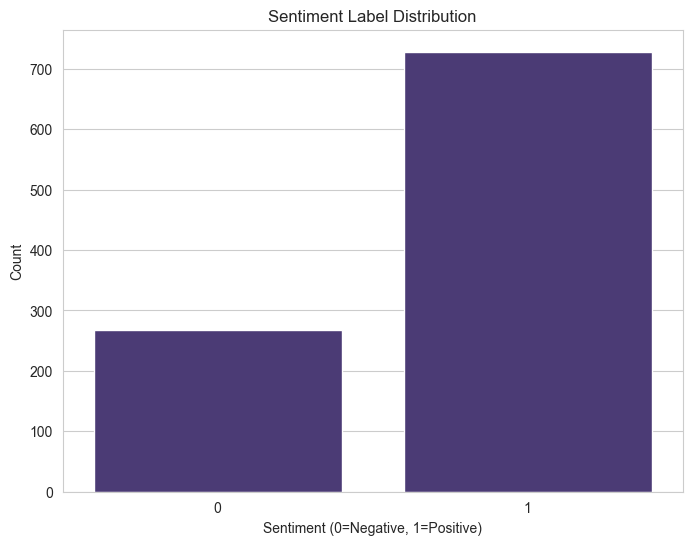

In [8]:
# Check sentiment distribution
sentiment_counts = feedback_data['Sentiment Label'].value_counts()
print("Sentiment Label Distribution:")
print(sentiment_counts)
print(f"Percentage of positive sentiment: {sentiment_counts[1] / len(feedback_data) * 100:.2f}%")

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment Label', data=feedback_data)
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.show()

Ratings Distribution:
Ratings
1    123
2    145
3    123
4    254
5    351
Name: count, dtype: int64


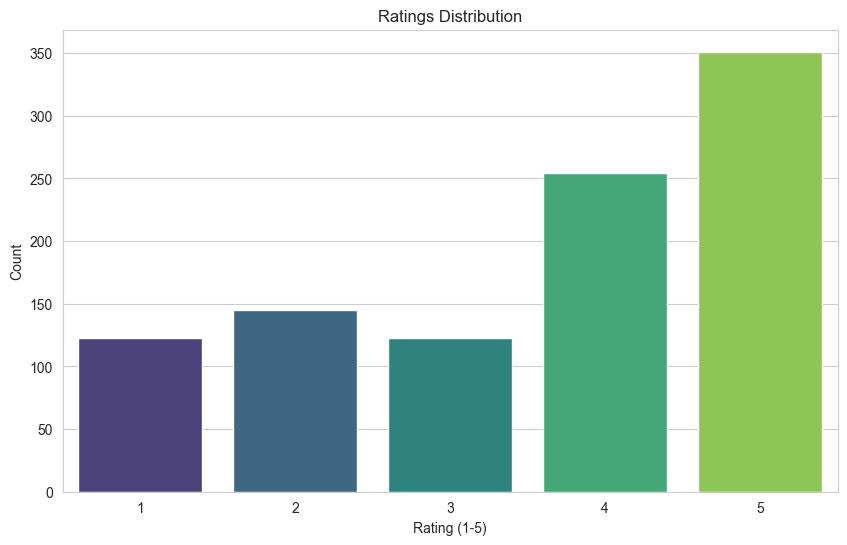

In [9]:
# Check ratings distribution
ratings_counts = feedback_data['Ratings'].value_counts().sort_index()
print("Ratings Distribution:")
print(ratings_counts)

# Visualize ratings distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Ratings', data=feedback_data, palette='viridis')
plt.title('Ratings Distribution')
plt.xlabel('Rating (1-5)')
plt.ylabel('Count')
plt.show()

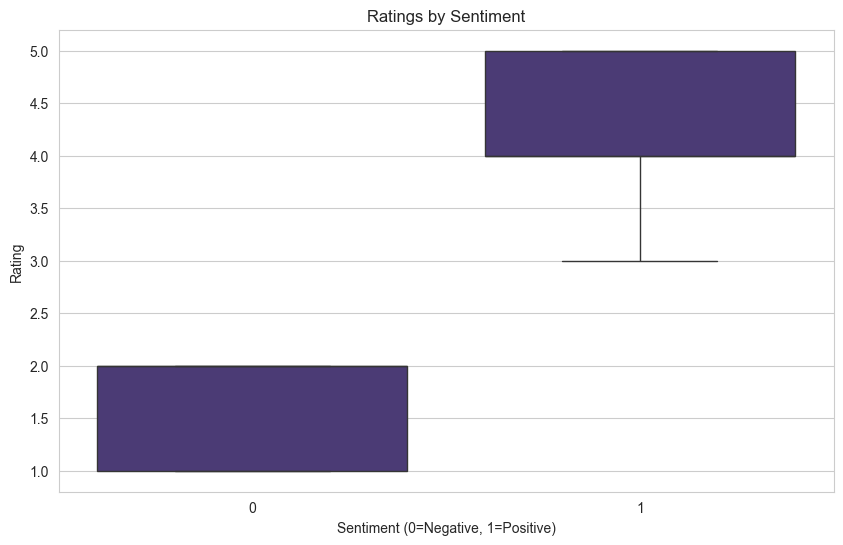

In [10]:
# Check relationship between sentiment and ratings
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment Label', y='Ratings', data=feedback_data)
plt.title('Ratings by Sentiment')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Rating')
plt.show()

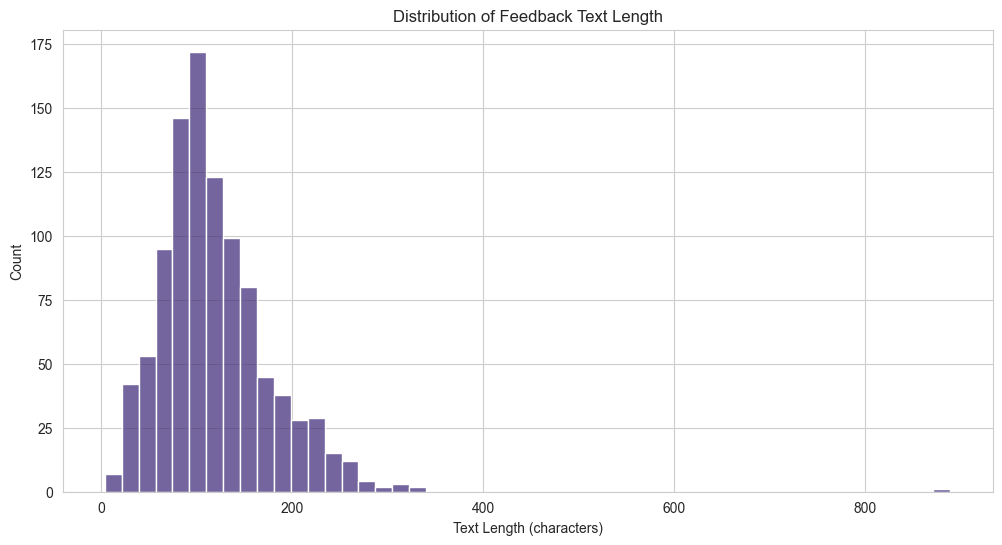

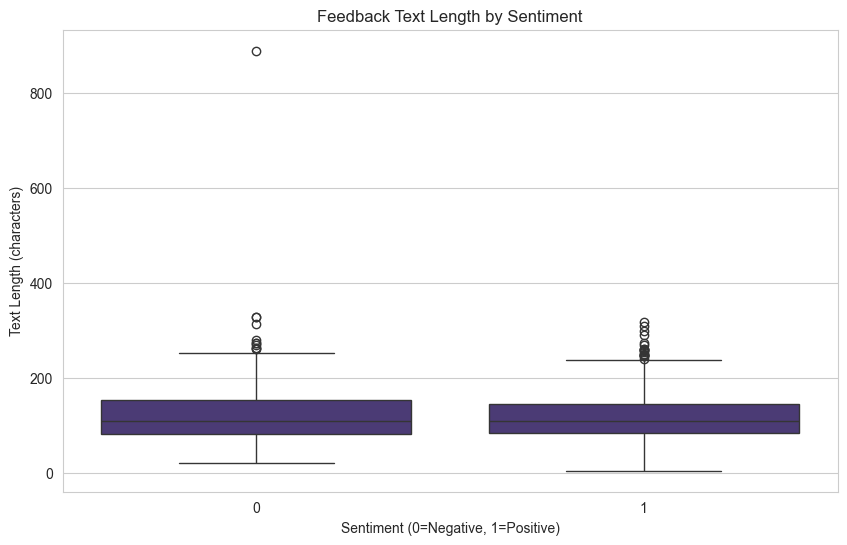

In [11]:
# Analyze feedback text length
feedback_data['text_length'] = feedback_data['Feedback'].apply(len)

# Visualize text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(feedback_data['text_length'], bins=50)
plt.title('Distribution of Feedback Text Length')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.show()

# Compare text length by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment Label', y='text_length', data=feedback_data)
plt.title('Feedback Text Length by Sentiment')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Text Length (characters)')
plt.show()

## 3. Text Preprocessing

In [12]:
def preprocess_text(text):
    """Preprocess text data for NLP analysis"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [13]:
# Apply preprocessing to feedback text
print("Preprocessing feedback text...")
feedback_data['processed_text'] = feedback_data['Feedback'].apply(preprocess_text)

# Display sample of original and processed text
sample_comparison = pd.DataFrame({
    'Original': feedback_data['Feedback'].head(5),
    'Processed': feedback_data['processed_text'].head(5)
})
sample_comparison

Preprocessing feedback text...


,Original,Processed
0,Good and clean hospital. There is great team o...,good clean hospital great team doctor good ot ...
1,Had a really bad experience during discharge. ...,really bad experience discharge need sensitive...
2,I have visited to take my second dose and Proc...,visited take second dose process really smooth...
3,That person was slightly clueless and offered...,person slightly clueless offered one package g...
4,There is great team of doctors and good OT fac...,great team doctor good ot facility


## 4. Text Visualization

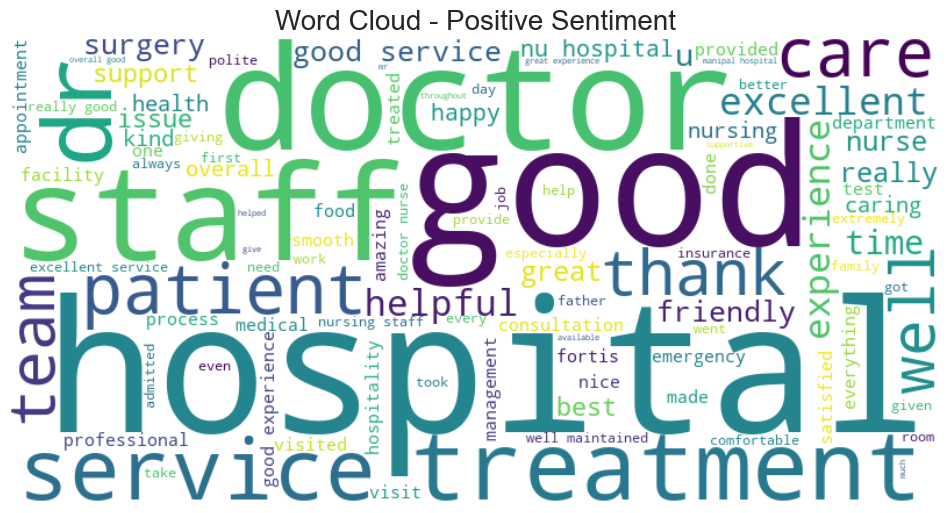

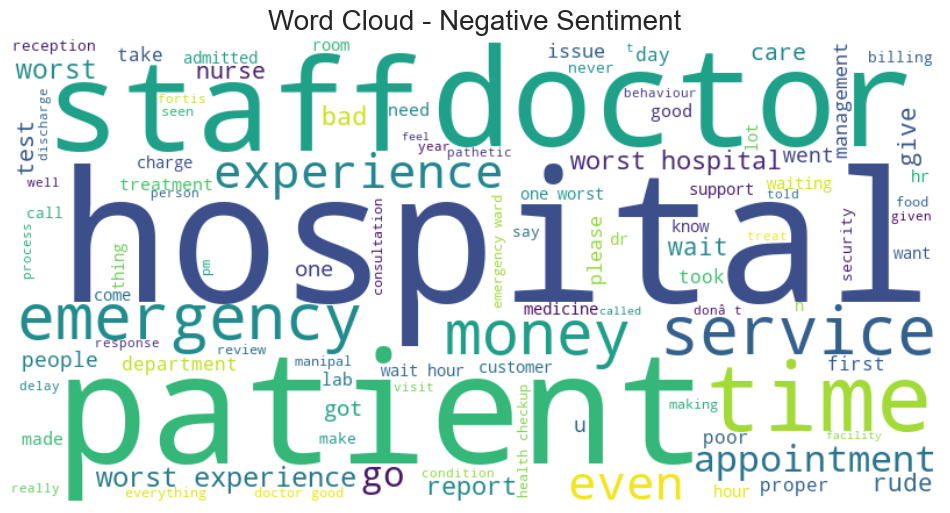

In [14]:
# Generate word clouds for positive and negative sentiment
def generate_wordcloud(text_series, title):
    """Generate and display word cloud from text series"""
    text = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         max_words=100, contour_width=3, contour_color='steelblue').generate(text)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Generate word clouds by sentiment
positive_text = feedback_data[feedback_data['Sentiment Label'] == 1]['processed_text']
negative_text = feedback_data[feedback_data['Sentiment Label'] == 0]['processed_text']

generate_wordcloud(positive_text, 'Word Cloud - Positive Sentiment')
generate_wordcloud(negative_text, 'Word Cloud - Negative Sentiment')

## 5. Feature Engineering

In [15]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_features = tfidf_vectorizer.fit_transform(feedback_data['processed_text'])

print(f"TF-IDF features shape: {tfidf_features.shape}")

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Sample TF-IDF features: {feature_names[:10]}")

TF-IDF features shape: (996, 5000)
Sample TF-IDF features: ['aashish' 'aashish ranjitha' 'abdominal' 'abdominal pain' 'abhijit'
 'abhijit bhograj' 'abhijit needed' 'abhinav' 'abhinav sir' 'abhishek']


In [16]:
# Extract additional text features
def extract_text_features(text):
    """Extract additional features from text"""
    if pd.isna(text):
        return pd.Series([0, 0, 0, 0])
    
    # Word count
    word_count = len(text.split())
    
    # Character count
    char_count = len(text)
    
    # Average word length
    words = text.split()
    avg_word_length = sum(len(word) for word in words) / max(1, len(words))
    
    # Sentence count
    sentence_count = text.count('.') + text.count('!') + text.count('?')
    sentence_count = max(1, sentence_count)  # Ensure at least 1 sentence
    
    return pd.Series([word_count, char_count, avg_word_length, sentence_count])

# Apply feature extraction
text_features = feedback_data['Feedback'].apply(extract_text_features)
text_features.columns = ['word_count', 'char_count', 'avg_word_length', 'sentence_count']

# Add features to dataframe
feedback_data = pd.concat([feedback_data, text_features], axis=1)

# Display sample with new features
feedback_data[['Feedback', 'word_count', 'char_count', 'avg_word_length', 'sentence_count']].head()

,Feedback,word_count,char_count,avg_word_length,sentence_count
0,Good and clean hospital. There is great team o...,47.0,273.0,4.808511,4.0
1,Had a really bad experience during discharge. ...,21.0,133.0,5.333333,2.0
2,I have visited to take my second dose and Proc...,32.0,198.0,5.218750,4.0
3,That person was slightly clueless and offered...,30.0,161.0,4.366667,1.0
4,There is great team of doctors and good OT fac...,10.0,52.0,4.300000,1.0


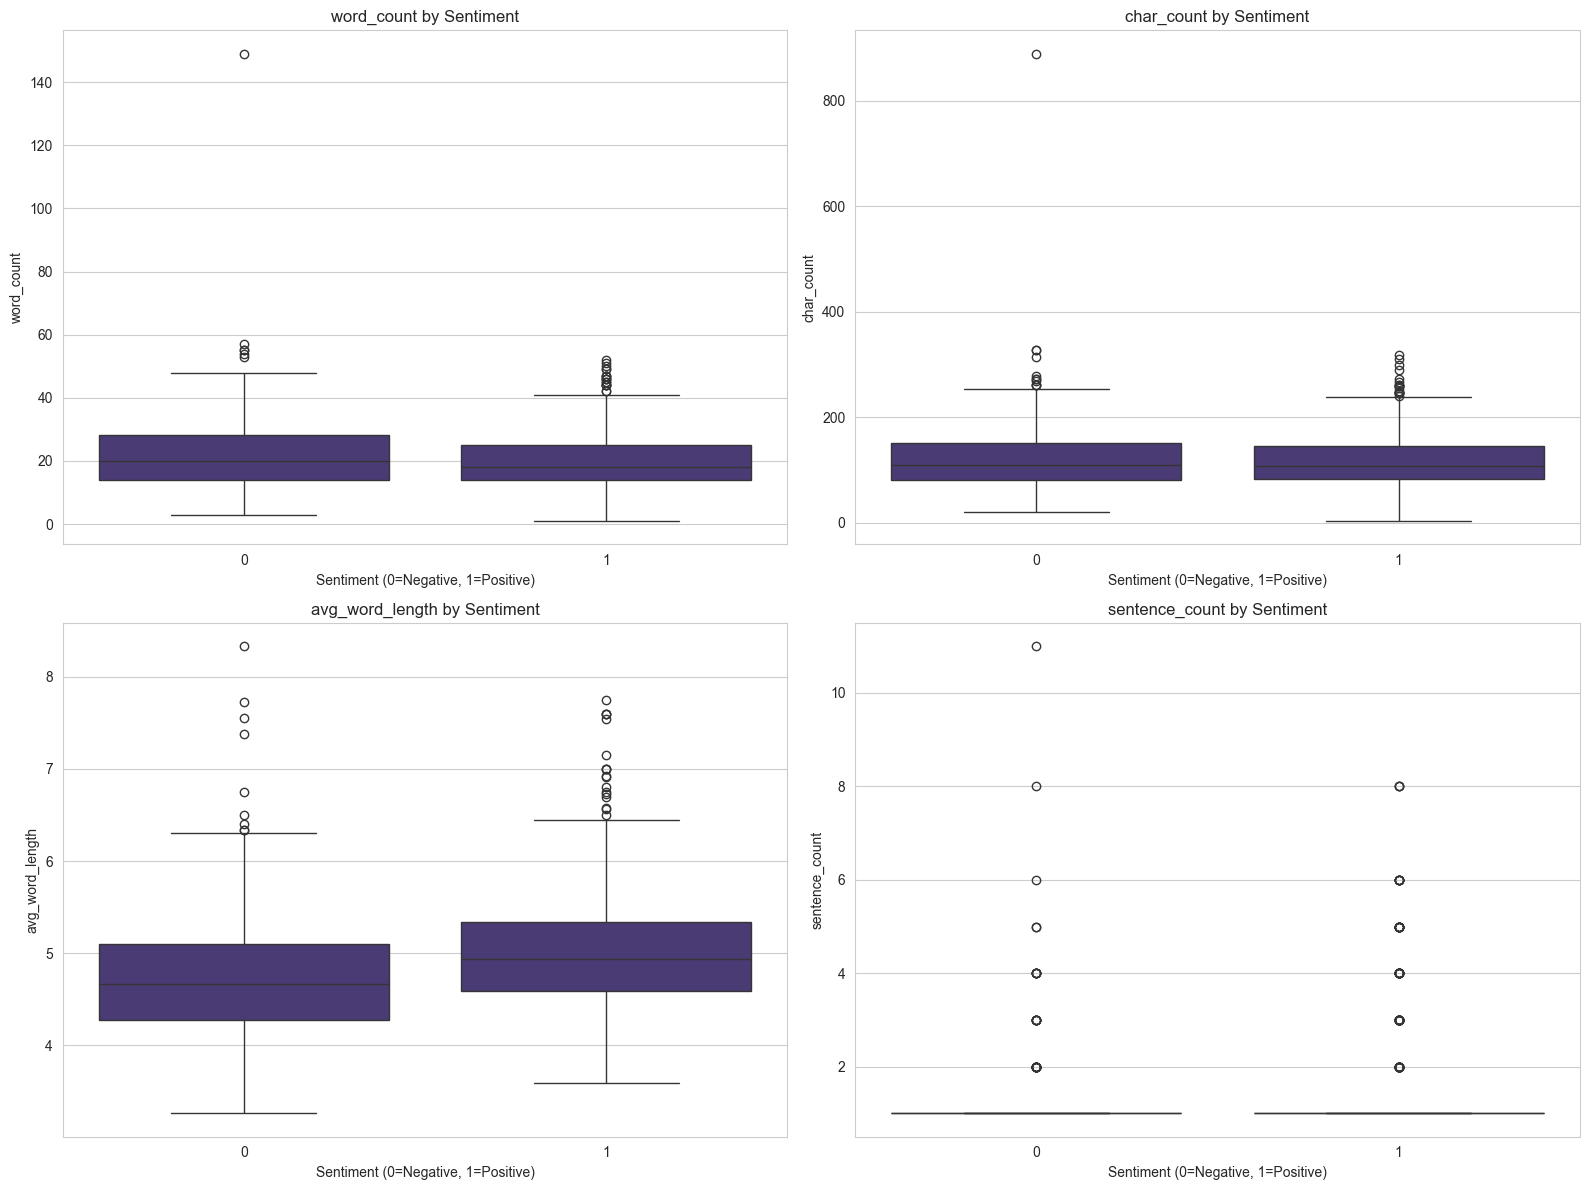

In [17]:
# Analyze relationship between text features and sentiment
text_feature_cols = ['word_count', 'char_count', 'avg_word_length', 'sentence_count']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(text_feature_cols):
    sns.boxplot(x='Sentiment Label', y=feature, data=feedback_data, ax=axes[i])
    axes[i].set_title(f'{feature} by Sentiment')
    axes[i].set_xlabel('Sentiment (0=Negative, 1=Positive)')
    
plt.tight_layout()
plt.show()

## 6. Prepare Data for NLP Models

In [18]:
# Convert TF-IDF features to DataFrame for easier handling
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=feature_names)

# Display sample of TF-IDF features
tfidf_df.iloc[:5, :10]

,aashish,aashish ranjitha,abdominal,abdominal pain,abhijit,abhijit bhograj,abhijit needed,abhinav,abhinav sir,abhishek
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Prepare data for transformer-based models (BERT, etc.)
# For transformer models, we'll use the original text
transformer_data = feedback_data[['Feedback', 'Sentiment Label', 'Ratings']].copy()
transformer_data.rename(columns={'Feedback': 'text', 'Sentiment Label': 'label'}, inplace=True)

# Display sample
transformer_data.head()

,text,label,Ratings
0,Good and clean hospital. There is great team o...,1,5
1,Had a really bad experience during discharge. ...,1,5
2,I have visited to take my second dose and Proc...,1,4
3,That person was slightly clueless and offered...,1,3
4,There is great team of doctors and good OT fac...,0,1


In [20]:
# Prepare data for traditional ML models
# Combine TF-IDF features with other text features
ml_data = pd.concat([tfidf_df, feedback_data[text_feature_cols]], axis=1)
ml_data['label'] = feedback_data['Sentiment Label']
ml_data['rating'] = feedback_data['Ratings']

print(f"ML data shape: {ml_data.shape}")

ML data shape: (996, 5005)


## 7. Save Processed Data

In [21]:
# Create directories for saving processed data
os.makedirs('../src/data/processed', exist_ok=True)

# Save processed data for traditional ML models
# Due to high dimensionality of TF-IDF features, save a reduced version
ml_data_reduced = ml_data.iloc[:, :500]  # Take first 500 features
ml_data_reduced.to_csv('../src/data/processed/patient_feedback_ml.csv', index=False)
print("Saved processed data for traditional ML models")

# Save processed data for transformer models
transformer_data.to_csv('../src/data/processed/patient_feedback_transformer.csv', index=False)
print("Saved processed data for transformer models")

# Save TF-IDF vectorizer for future use
import joblib
os.makedirs('../src/models/nlp', exist_ok=True)
joblib.dump(tfidf_vectorizer, '../src/models/nlp/tfidf_vectorizer.pkl')
print("Saved TF-IDF vectorizer")

Saved processed data for traditional ML models
Saved processed data for transformer models
Saved TF-IDF vectorizer


## 8. Summary

In this notebook, we have:
1. Loaded and explored the Patient Feedback dataset
2. Performed exploratory data analysis on sentiment and ratings
3. Preprocessed text data using NLP techniques
4. Visualized text data using word clouds
5. Engineered features for NLP analysis
6. Prepared data for both traditional ML and transformer-based models
7. Saved processed data for future modeling tasks

The processed data is now ready for developing NLP models for sentiment analysis and other text-based tasks.